In [1]:
import os.path as op

import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram

import matplotlib.pyplot as plt

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from fooof import FOOOFGroup, FOOOF

from timescales.est.psd import fit_psd, convert_knee_val

### Sliding Window Tau

#### Background
This notebook uses fcx-1, from CRCNS, to investigate a sliding window tau estimation. This data consists of >= 7 minutes of wake followed by 20 minutes of sleep - this cycle of wake/sleep periods may occur multiple times per recording. I still need to incorporate behavioral data, however, from Watson at al. 2016, they show that overall power increases, which should correspond to segments in the timeseries with relatively large amplitude, during non-REM episodes. Thus we should see a correlation between changes in timescale and ampltidue of the signal.


#### Method / Results
A 240 minute LFP signal is broken into 10s windows and tau is estimated using SpecParam. The results show a moderate degree of correlation between tau and LFP amplitude, specifically that long taus correspond to periods of high LFP amplitude (== non-REM episodes).

#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
data_dir = '/home/rph/Projects/timescale-methods/data_unpack/20140526_277um'
data_mat_dir = '/home/rph/Projects/timescale-methods/fcx1/data_mats'

In [3]:
fs = 1250

lfp_file = op.join(data_mat_dir, 'data18.mat')

sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)

times = np.arange(0, len(sig_lfp)/fs, 1/fs)

In [5]:
win_len = 20

n_windows = int(np.floor(len(sig_lfp) / (fs * win_len)))
n_samples = int(n_windows * win_len * fs)
_sig_lfp = sig_lfp.copy()

_sig_lfp = _sig_lfp[:n_samples].reshape(n_windows, -1)

In [6]:
freqs, powers = compute_spectrum(_sig_lfp, fs, f_range=(0, 100))

In [7]:
fooof_init = dict(max_n_peaks=4, peak_threshold=3)

fms, knee_freqs, knee_taus = fit_psd(freqs, powers, (1, 80), fooof_init=fooof_init,
                                     knee_bounds=(.01, 1000000), n_jobs=-1, progress='tqdm.notebook')

Running FOOOFGroup:   0%|          | 0/678 [00:00<?, ?it/s]

(-10.0, 25.0)

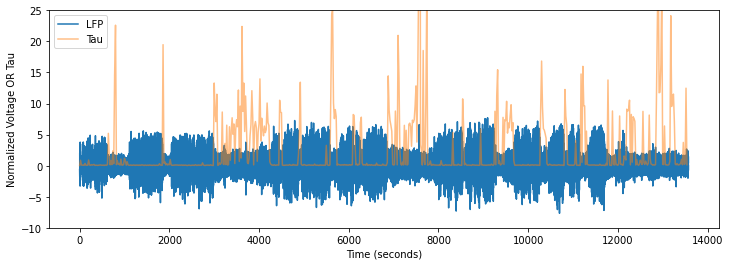

In [10]:
t_starts = [(w * win_len * fs) for w in range(n_windows)]

plt.figure(figsize=(12, 4))
plt.plot(times, sig_lfp, label='LFP')
plt.plot(times[t_starts], knee_taus, alpha=.5, label='Tau')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Voltage OR Tau')
plt.ylim(-10, 25)